In [90]:
import torch
from torch.utils.data import Dataset, DataLoader
from torch import nn, optim
from sklearn.model_selection import train_test_split
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import glob
import os
import yaml
from sklearn.preprocessing import MinMaxScaler, RobustScaler


In [91]:
#load Accelerator data



d = yaml.safe_load(open('/home/sanjeev/GPT/simulation_2023-08-09_14-26-39/dump.yaml'))
data = pd.DataFrame(d['data'])
data.index = list(map(int, data.index))
data.sort_index(inplace=True)
len(data)


data['bunch_length'] = data['bunch_length']*1e-12

data = data[data['emit_mean'] < 6e-6]



print(len(data))
data.head()
print(data['sol_var'])

# Displaying the smallest values of 'sol_var' in the filtered data
smallest_values = data['sol_var'].nsmallest(10)
smallest_values
# Dropping the specific value with index 799
data.drop(799, inplace=True, errors='ignore')

# Checking if the value has been dropped
data.loc[799] if 799 in data.index else "Value with index 799 has been dropped."



In [ ]:
data.tail()

,QUAD:IN10:361:BCTRL,QUAD:IN10:371:BCTRL,QUAD:IN10:425:BCTRL,QUAD:IN10:441:BCTRL,QUAD:IN10:511:BCTRL,QUAD:IN10:525:BCTRL,alpha_x,alpha_y,beta_x,beta_y,...,gun_phase,laser_pulse_length,norm_emit_x,norm_emit_y,num_particles,sigx,sigy,sol_var,xopt_error,xopt_runtime
794,-0.230593,0.226143,0.182532,0.182994,0.207753,-0.084514,76.583297,-145.362881,32.645756,97.704646,...,270.237682,0.0,0.000004,0.000004,9982,0.744592,1.255220,0.241473,False,85.990053
796,0.024223,0.052178,-0.118155,0.018806,-0.204270,0.247443,17.475757,-6.558114,15.955035,18.450512,...,270.900541,0.0,0.000005,0.000005,9979,0.565495,0.596408,0.228903,False,80.285690
797,-0.146343,0.161917,-0.019546,-0.077672,0.266309,-0.069571,-1.048077,-3.166562,7.746628,3.082401,...,270.612131,0.0,0.000004,0.000004,9977,0.464002,0.302910,0.254493,False,83.666997
798,0.048459,0.049628,0.177224,-0.246693,0.089808,-0.045924,0.681505,-190.818607,0.093068,179.181709,...,270.557613,0.0,0.000005,0.000005,9976,0.057583,1.841350,0.228947,False,78.639960
800,0.108900,0.151227,-0.188447,0.040909,0.281221,-0.081262,1.861264,2.113121,118.009611,35.627684,...,270.558068,0.0,0.000004,0.000004,9976,1.450960,0.924271,0.242222,False,85.951043


In [ ]:
# Listing the columns of the 'data' dataframe
columns_of_data = data.columns.tolist()
columns_of_data


['QUAD:IN10:361:BCTRL',
 'QUAD:IN10:371:BCTRL',
 'QUAD:IN10:425:BCTRL',
 'QUAD:IN10:441:BCTRL',
 'QUAD:IN10:511:BCTRL',
 'QUAD:IN10:525:BCTRL',
 'alpha_x',
 'alpha_y',
 'beta_x',
 'beta_y',
 'bunch_charge',
 'bunch_charge_final',
 'bunch_length',
 'emit_mean',
 'emit_x',
 'emit_y',
 'energy',
 'eta_x',
 'eta_y',
 'etap_x',
 'etap_y',
 'gamma_x',
 'gamma_y',
 'gun_phase',
 'laser_pulse_length',
 'norm_emit_x',
 'norm_emit_y',
 'num_particles',
 'sigx',
 'sigy',
 'sol_var',
 'xopt_error',
 'xopt_runtime']

In [ ]:
dropout_var = .1

class Net(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(Net, self).__init__()
        
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.dropout1 = nn.Dropout(dropout_var)
        
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.dropout2 = nn.Dropout(dropout_var)
        
        self.fc3 = nn.Linear(hidden_size, hidden_size)
        self.dropout3 = nn.Dropout(dropout_var)
        
        self.fc4 = nn.Linear(hidden_size, hidden_size)  # New layer
        self.dropout4 = nn.Dropout(dropout_var)        # New dropout for the added layer
        
        self.fc5 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = torch.tanh(self.fc1(x))
        x = self.dropout1(x)
        
        x = torch.tanh(self.fc2(x))
        x = self.dropout2(x)
        
        x = torch.tanh(self.fc3(x))
        x = self.dropout3(x)
        
        x = torch.tanh(self.fc4(x))  # Pass through the new layer
        x = self.dropout4(x)        # Apply dropout after the new layer
        
        x = self.fc5(x)
        
        return x


Epoch 1 - Training loss: 0.25184725522994994 - Validation loss: 0.1679392009973526
Epoch 2 - Training loss: 0.19222663044929506 - Validation loss: 0.17553546279668808
Epoch 3 - Training loss: 0.18414691388607024 - Validation loss: 0.15139641612768173
Epoch 4 - Training loss: 0.17315772771835328 - Validation loss: 0.1485208123922348
Epoch 5 - Training loss: 0.17054589092731476 - Validation loss: 0.14613452553749084
Epoch 6 - Training loss: 0.16267366707324982 - Validation loss: 0.14007355272769928
Epoch 7 - Training loss: 0.15711428523063659 - Validation loss: 0.1349887251853943
Epoch 8 - Training loss: 0.15387610495090484 - Validation loss: 0.12695077434182167
Epoch 9 - Training loss: 0.1496947318315506 - Validation loss: 0.12366075813770294
Epoch 10 - Training loss: 0.14293821454048156 - Validation loss: 0.11952617019414902
Epoch 11 - Training loss: 0.13916829973459244 - Validation loss: 0.12242895364761353
Epoch 12 - Training loss: 0.14191040694713591 - Validation loss: 0.11556570976

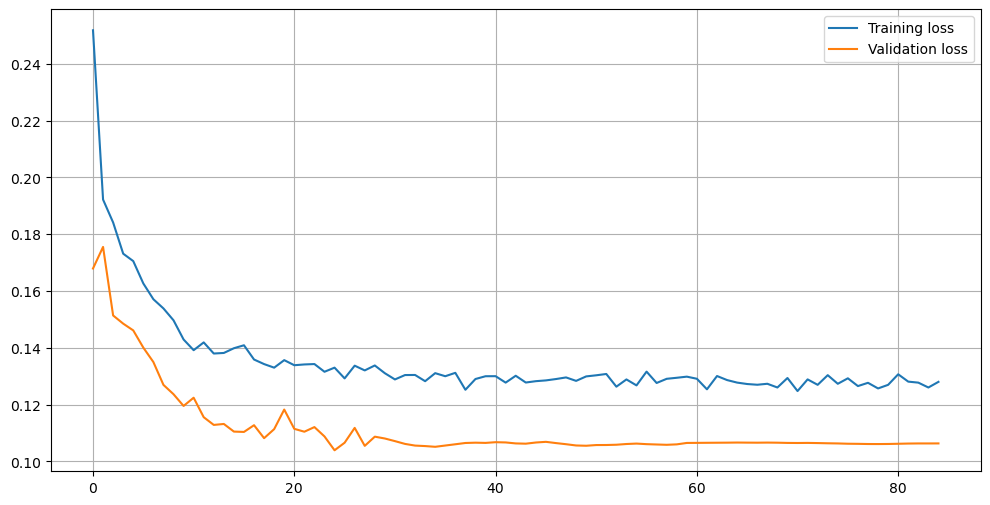

In [ ]:
import pandas as pd
import torch
from torch import nn
from torch import optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from math import sqrt
#load Accelerator data




# Define the features and targets
features = ['sol_var','gun_phase','bunch_charge','laser_pulse_length','QUAD:IN10:361:BCTRL','QUAD:IN10:371:BCTRL','QUAD:IN10:425:BCTRL','QUAD:IN10:441:BCTRL','QUAD:IN10:511:BCTRL','QUAD:IN10:525:BCTRL']
targets = ['emit_mean','bunch_length','norm_emit_x','norm_emit_y','sigx','sigy']

# Create separate scalers for features and targets
scaler_features = MinMaxScaler()
scaler_targets = MinMaxScaler()

# Fit the scalers and transform the data
data[features] = scaler_features.fit_transform(data[features])
data[targets] = scaler_targets.fit_transform(data[targets])


# Split the data into training, testing, and validation sets
train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)
train_data, val_data = train_test_split(train_data, test_size=0.25, random_state=42) 






# Create PyTorch Datasets and DataLoaders
batch_size = 32
train_dataset = TensorDataset(torch.tensor(train_data[features].values).float(), torch.tensor(train_data[targets].values).float())
val_dataset = TensorDataset(torch.tensor(val_data[features].values).float(), torch.tensor(val_data[targets].values).float())
test_dataset = TensorDataset(torch.tensor(test_data[features].values).float(), torch.tensor(test_data[targets].values).float())

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


# Initialize the network and define the loss function and the optimizer
net = Net(input_size=len(features), hidden_size=100, output_size=len(targets))
criterion = nn.L1Loss()  # Changed this line to use MAE
optimizer = optim.Adam(net.parameters(), lr=0.001)
# Add a scheduler
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)
# Training loop with early stopping
num_epochs = 1000
patience = 60
early_stopping_counter = 0
best_loss = float('inf')

train_loss = []
val_loss = []
learning_rates_extracted = []
for epoch in range(num_epochs):
    net.train()
    running_loss = 0.0
    for i, data in enumerate(train_dataloader, 0):
        inputs, labels = data[0], data[1]

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        
    #extract data to plot learning rate    
    for param_group in optimizer.param_groups:
        learning_rates_extracted.append(param_group['lr'])    
        
    # Call the learning rate scheduler at the end of the epoch a
    scheduler.step()


    # validation part
    net.eval()
    validation_loss = 0.0
    with torch.no_grad():
        for i, data in enumerate(val_dataloader, 0):
            inputs, labels = data[0], data[1]
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            validation_loss += loss.item()

    running_loss /= len(train_dataloader)
    validation_loss /= len(val_dataloader)
    print(f"Epoch {epoch+1} - Training loss: {running_loss} - Validation loss: {validation_loss}")
    
    train_loss.append(running_loss)
    val_loss.append(validation_loss)
    
    # early stopping
    if validation_loss < best_loss:
        best_loss = validation_loss
        early_stopping_counter = 0
    else:
        early_stopping_counter += 1
        
    if early_stopping_counter >= patience:
        print('Early stopping...')
        break

# Define the model evaluation function
def evaluate_model(model, dataloader):
    model.eval()
    mse_loss = 0.0
    mae_loss = 0.0
    n_samples = 0
    with torch.no_grad():
        for i, data in enumerate(dataloader, 0):
            inputs, labels = data[0], data[1]
            outputs = model(inputs)
            mse_loss += criterion(outputs, labels).item() * inputs.shape[0]
            mae_loss += torch.nn.L1Loss()(outputs, labels).item() * inputs.shape[0]
            n_samples += inputs.shape[0]
    mse_loss /= n_samples
    rmse_loss = sqrt(mse_loss)
    mae_loss /= n_samples
    return mse_loss, rmse_loss, mae_loss

# Evaluate the model on the test data
mse_loss, rmse_loss, mae_loss = evaluate_model(net, test_dataloader)
print(f'MSE Loss: {mse_loss:.6f}, RMSE Loss: {rmse_loss:.6f}, MAE Loss: {mae_loss:.6f}')

# After training, we'll plot the training and validation loss
plt.figure(figsize=(12,6))
plt.plot(train_loss, label='Training loss')
plt.plot(val_loss, label='Validation loss')
plt.legend()
plt.grid(True)
plt.show()


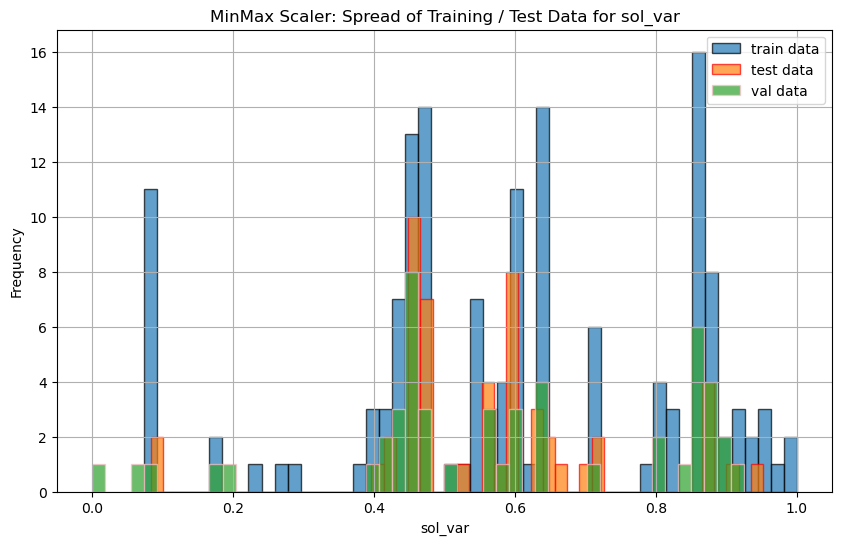

In [ ]:
# Extracting 'sol_var' column from the train_data DataFrame
sol_var_data_train = train_data['sol_var']
sol_var_data_test = test_data['sol_var']
sol_var_data_val = val_data['sol_var']
# Plotting the histogram
plt.figure(figsize=(10, 6))
plt.hist(sol_var_data_train, label="train data", bins=50, edgecolor='black', alpha=0.7)
plt.hist(sol_var_data_test,label="test data", bins=50, edgecolor='red', alpha=0.7)
plt.hist(sol_var_data_val,label="val data", bins=50, edgecolor='pink', alpha=0.7)


plt.title('MinMax Scaler: Spread of Training / Test Data for sol_var')
plt.xlabel('sol_var')
plt.ylabel('Frequency')
plt.grid(True)
plt.legend()
plt.show()

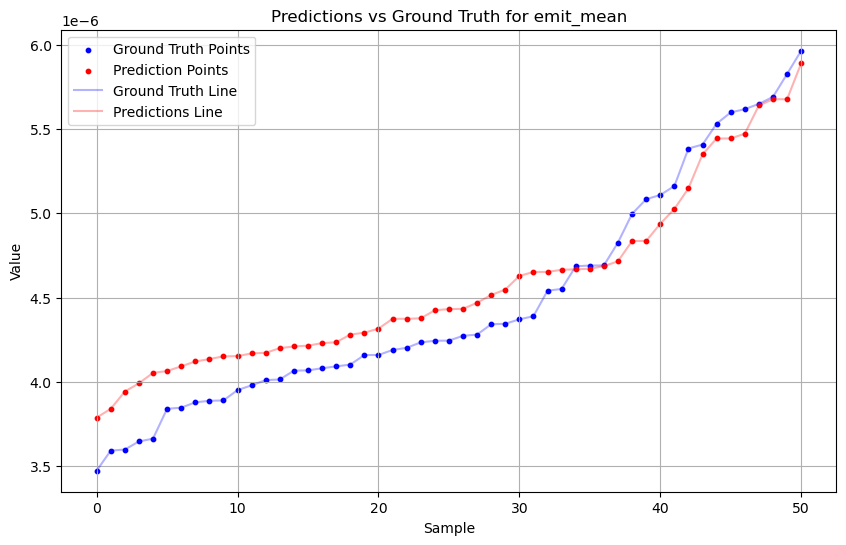

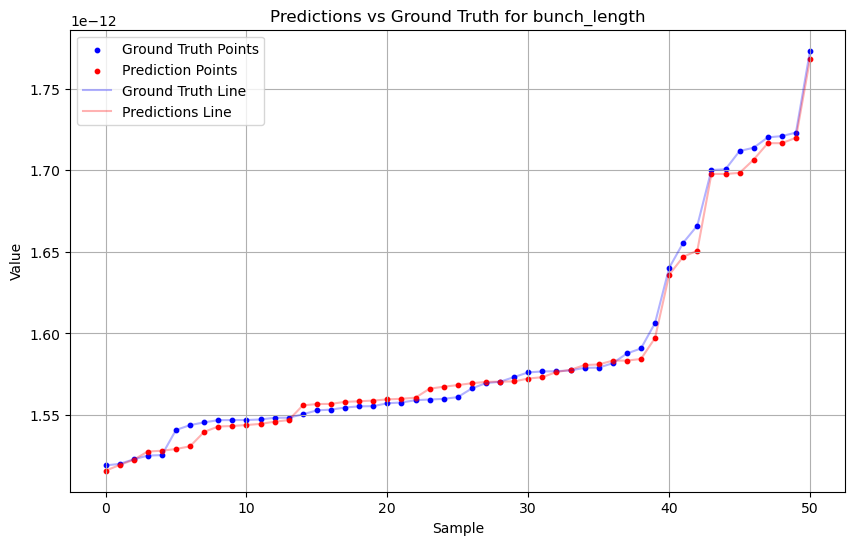

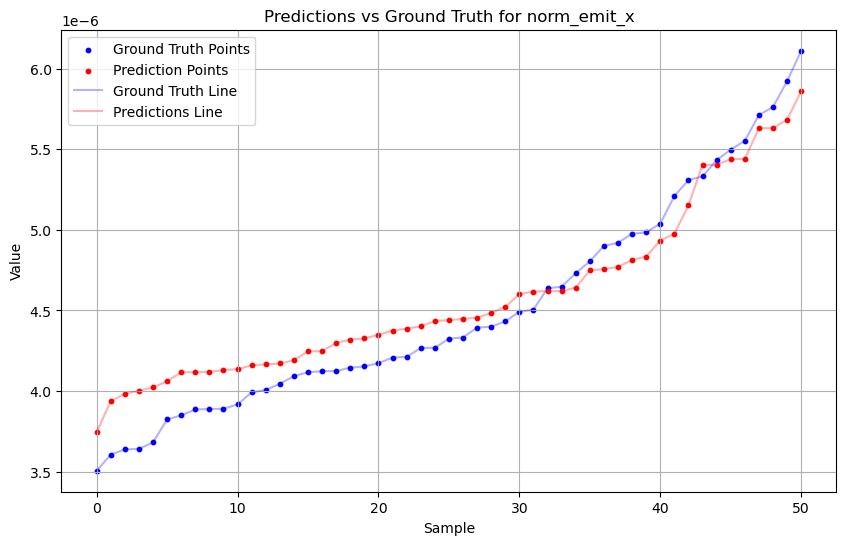

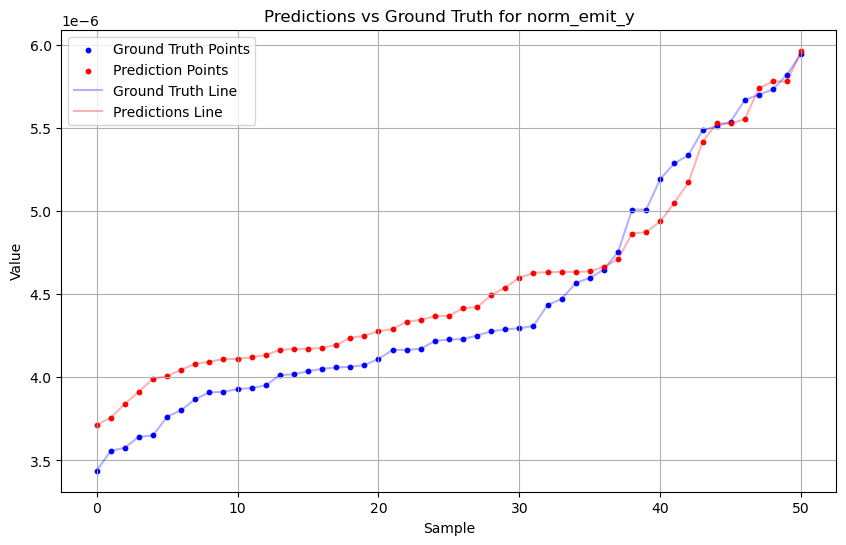

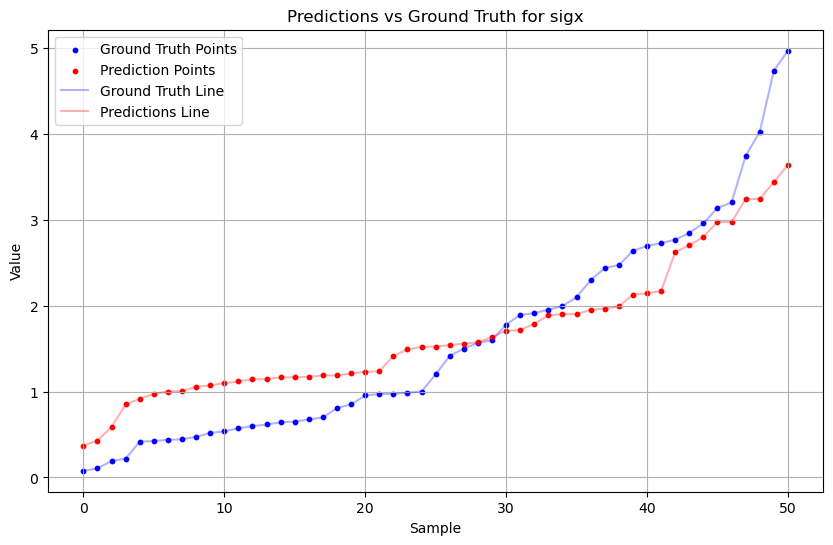

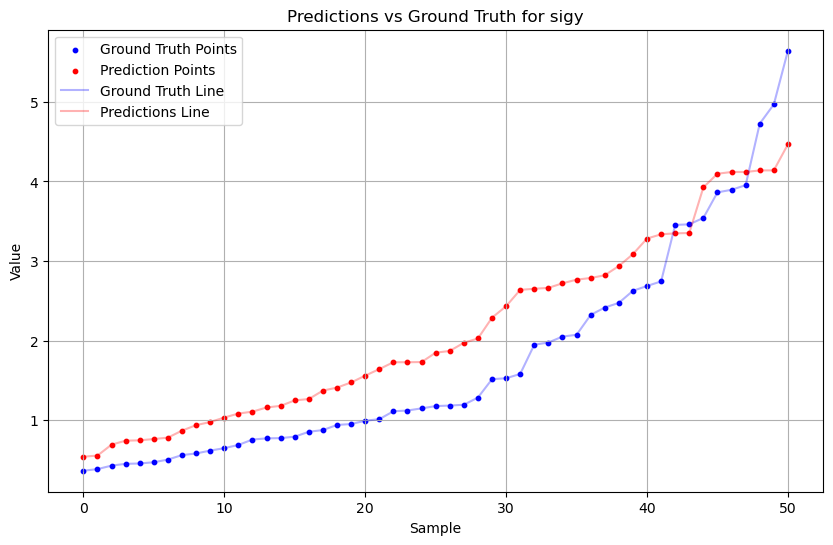

In [ ]:
import numpy as np

# Generate predictions for test set
net.eval()
with torch.no_grad():
    predictions = net(torch.tensor(test_data[features].values).float())

# Convert the tensor to a numpy array
predictions = predictions.numpy()
predictions = scaler_targets.inverse_transform(predictions)
actual_data = scaler_targets.inverse_transform(test_data[targets].values)

# Create a dataframe of predictions
pred_df = pd.DataFrame(predictions, columns=targets, index=test_data.index)
test_data = pd.DataFrame(actual_data, columns=targets, index=test_data.index)

# Select targets to plot
targets_to_plot = targets

for target in targets_to_plot:
    # Sort the ground truth and predictions by the magnitude of the predictions
    sorted_test_data = test_data.sort_values(by=target)
    sorted_pred_df = pred_df.sort_values(by=target)

    # Plot the ground truth and predictions
    plt.figure(figsize=(10, 6))
    
    # Scatter plots
    plt.scatter(range(len(sorted_test_data)), sorted_test_data[target].values, s=10, color='blue', label='Ground Truth Points')
    plt.scatter(range(len(sorted_pred_df)), sorted_pred_df[target].values, s=10, color='red', label='Prediction Points')

    # Line plots
    plt.plot(sorted_test_data[target].values, label='Ground Truth Line', color='blue', alpha=0.3)
    plt.plot(sorted_pred_df[target].values, label='Predictions Line', color='red', alpha=0.3)
    
    plt.title(f"Predictions vs Ground Truth for {target}")
    plt.xlabel('Sample')
    plt.ylabel('Value')
    plt.legend()
    plt.grid(True)
    plt.show()

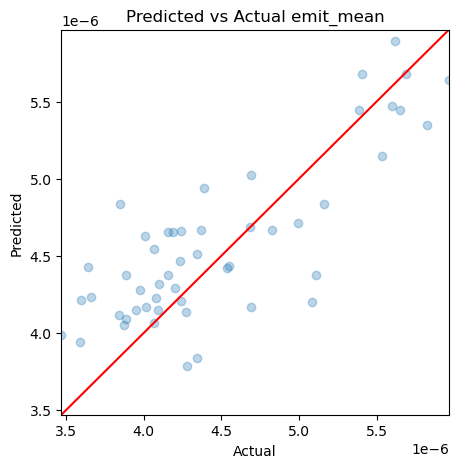

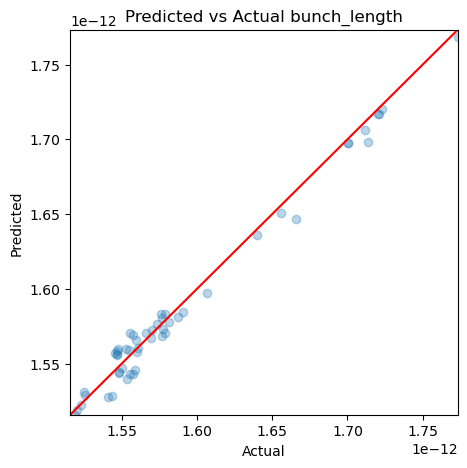

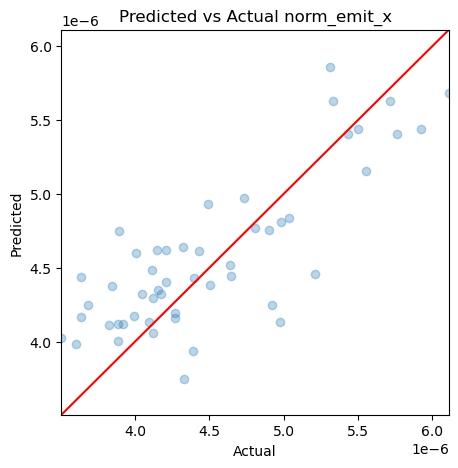

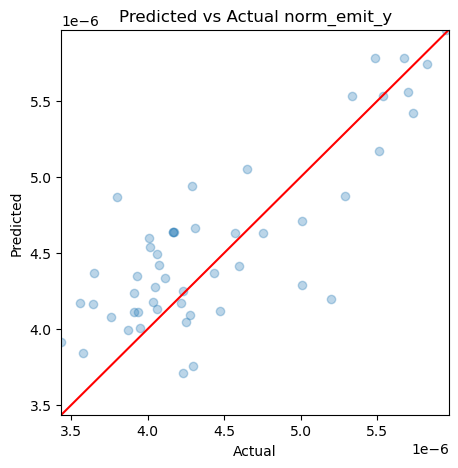

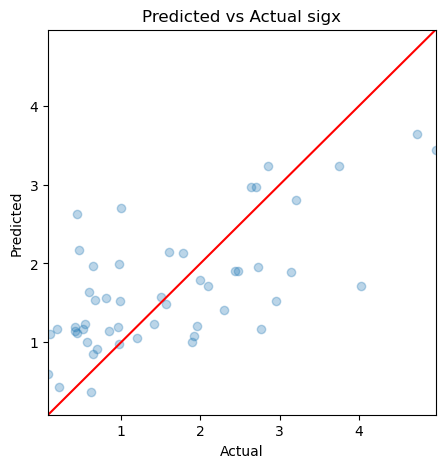

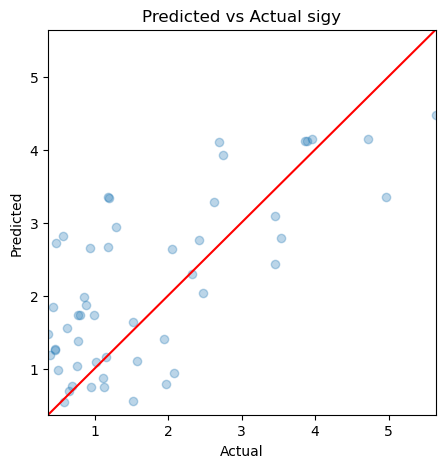

In [ ]:
# calculate predictions
net.eval()
predictions = []
actuals = []
with torch.no_grad():
    for data, target in test_dataloader:
        output = net(data)
        predictions.append(output.numpy())
        actuals.append(target.numpy())
predictions = np.concatenate(predictions, axis=0)
actuals = np.concatenate(actuals, axis=0)

# inverse transform the data
# Assume `predictions_scaled` is a numpy array containing model predictions in the scaled form
predictions = scaler_targets.inverse_transform(predictions)
actuals = scaler_targets.inverse_transform(actuals)

# create scatter plots
for i, target in enumerate(targets):
    plt.figure(figsize=(5, 5))
    plt.scatter(actuals[:, i], predictions[:, i], alpha=0.3)
    plt.title(f'Predicted vs Actual {target}')
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    max_val = max(actuals[:, i].max(), predictions[:, i].max())
    min_val = min(actuals[:, i].min(), predictions[:, i].min())
    plt.xlim(min_val, max_val)
    plt.ylim(min_val, max_val)
    plt.plot([min_val, max_val], [min_val, max_val], color='red')
    plt.show()


import numpy as np
import matplotlib.pyplot as plt

# Generate a grid of points
gun_phase_values = np.linspace(200, 300, 100)
sol_var_values = np.linspace(0.1, 0.3, 100)

# Transform variable range using the scaler for features
gun_phase_values_scaled = scaler_features.transform(np.array([[200, 0.2],[300, 0.2]]))[:,0]
sol_var_values_scaled = scaler_features.transform(np.array([[280, 0.1],[280, 0.3]]))[:,1]

gun_phase_values_scaled = np.linspace(gun_phase_values_scaled[0], gun_phase_values_scaled[1], 100)
sol_var_values_scaled = np.linspace(sol_var_values_scaled[0], sol_var_values_scaled[1], 100)

# Create an empty array to hold the predictions
predictions = np.zeros((100, 100, len(targets)))

# Predict the outputs for each point in the grid
for i, gun_phase in enumerate(gun_phase_values_scaled):
    for j, sol_var in enumerate(sol_var_values_scaled):
        input_features = torch.tensor([gun_phase, sol_var]).float().unsqueeze(0)
        prediction = net(input_features)
        predictions[i, j, :] = prediction.detach().numpy()

# Plot the predicted outputs
for target_idx, target in enumerate(targets):
    plt.figure(figsize=(10, 6))
    plt.contourf(gun_phase_values, sol_var_values, predictions[:, :, target_idx])
    plt.title(f"Predicted {target} for different phase and solenoid values")
    plt.xlabel('Phase')
    plt.ylabel('Solenoid')
    plt.colorbar(label=target)
    plt.show()


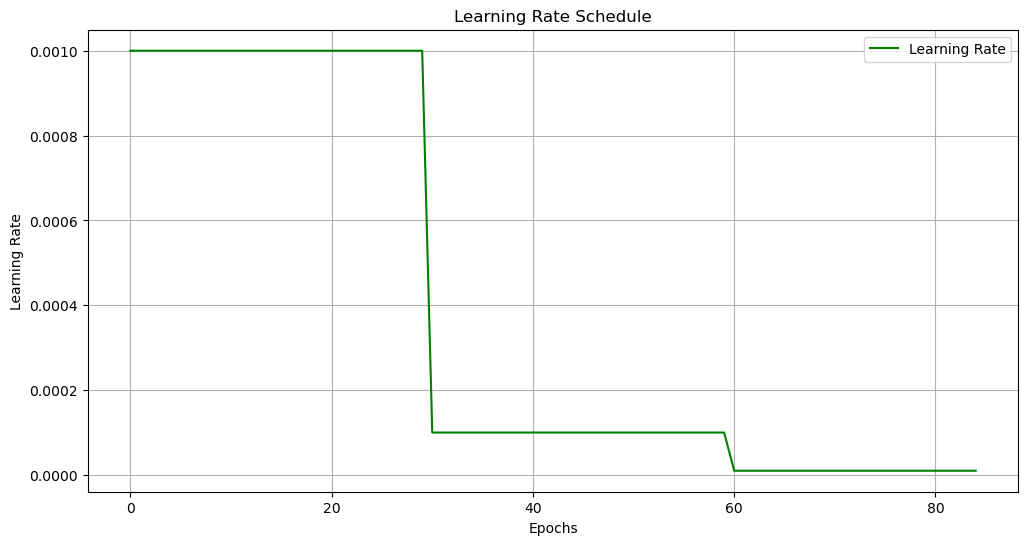

In [ ]:
# Plotting the Learning Rate Schedule
plt.figure(figsize=(12,6))
plt.plot(learning_rates_extracted, label='Learning Rate', color='green')
plt.xlabel('Epochs')
plt.ylabel('Learning Rate')
plt.title('Learning Rate Schedule')
plt.legend()
plt.grid(True)
plt.show()

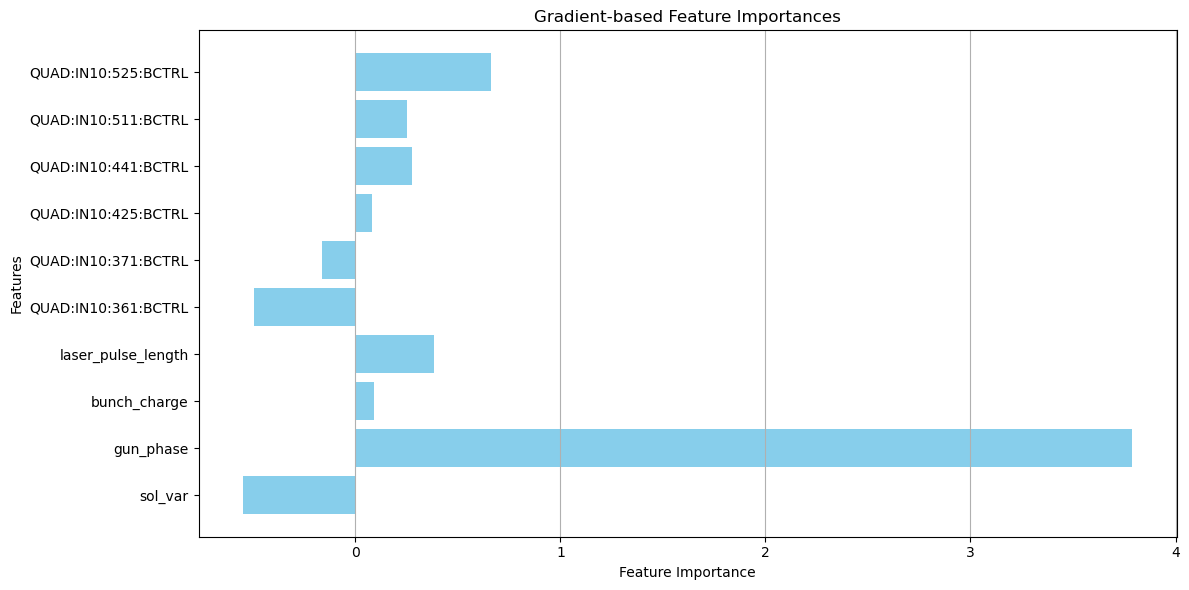

In [ ]:
# 1. Pick a sample from the dataset
sample_input, sample_output = next(iter(train_dataloader))
sample_input.requires_grad = True  # Set requires_grad to True for computing gradient

# 2. Forward pass the sample through the model
net.eval()
predictions = net(sample_input)

# 3. Compute the gradient of the output with respect to the input features.
# We will consider the sum of the predictions to compute an aggregated importance.
predictions.sum().backward()

# 4. Extract the gradients (feature importances)
feature_importances = sample_input.grad.mean(dim=0).detach().numpy()

feature_importances

import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.barh(features, feature_importances, color='skyblue')
plt.xlabel("Feature Importance")
plt.ylabel("Features")
plt.title("Gradient-based Feature Importances")
plt.grid(axis='x')
plt.tight_layout()
plt.show()

